In [1]:
import os
import json
from collections import defaultdict, OrderedDict
from os import path
import numpy as np

In [2]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            data.append(json.loads(line.strip()))
    
    return data

In [3]:
def get_cluster_spans(coref_chains):
    cluster_spans = []
    for chain in coref_chains:
        min_start = 1e9
        max_end = 0
        for (span_start, span_end) in chain:
            min_start = min(span_start, min_start)
            max_end = max(span_end, max_end)
            
        cluster_spans.append((min_start, max_end))
    return cluster_spans

In [4]:
def get_max_active_chains(cluster_spans):
    last_mention_idx = max([span_end for _, span_end in cluster_spans])
    num_clusters = len(cluster_spans)
    
    # Boolean variable that marks whether a cluster is active at certain time step or not
    active_chains = np.zeros((num_clusters, last_mention_idx), dtype=np.int32)
    for idx, (span_start, span_end) in enumerate(cluster_spans):
        active_chains[idx, span_start:span_end + 1] = 1
    
    active_chain_sum = np.sum(active_chains, axis=0)
    assert(last_mention_idx == len(active_chain_sum)) # Just to make sure summing over right dimension
    
    return np.max(active_chain_sum), np.argmax(active_chain_sum)

In [5]:
def get_doc_tokens(sentences):
    doc_tokens = []
    for sent in sentences:
        doc_tokens.extend(sent)
    return doc_tokens

In [6]:
def get_stats_for_file(train_file):
    print(train_file)
    data = load_jsonl(train_file)
    max_active_chains = 0
    corr_doc_idx = None
    within_doc_idx = None

    chain_spread = []
    active_chains = []
    for doc_idx, instance in enumerate(data):
        cluster_spans = get_cluster_spans(instance["clusters"])
        if len(cluster_spans):
            for (span_start, span_end) in cluster_spans:
                chain_spread.append(span_end - span_start)
            doc_tokens = get_doc_tokens(instance["sentences"])
            instance_max_active_chains, instance_within_doc_idx = get_max_active_chains(cluster_spans)
            if max_active_chains < instance_max_active_chains:
                max_active_chains = instance_max_active_chains
                corr_doc_idx = doc_idx
                within_doc_idx = instance_within_doc_idx
            
            active_chains.append((instance["doc_key"], instance_max_active_chains))
    print("Max active chains: {} present in {}".format(max_active_chains, data[corr_doc_idx]["doc_key"]))
    return active_chains

In [7]:
data_dir = "/home/shtoshni/Research/litbank_coref/data/litbank/independent/0"
train_file = path.join(data_dir, "train.512.jsonlines")
active_chains = get_stats_for_file(train_file)

/home/shtoshni/Research/litbank_coref/data/litbank/independent/0/train.512.jsonlines
Max active chains: 18 present in 2891_howards_end_brat_0


In [8]:
data_dir = "/home/shtoshni/Research/litbank_coref/data/ontonotes/independent"
train_file = path.join(data_dir, "train.512.jsonlines")
active_chains = get_stats_for_file(train_file)

genres = {"bc": 0, "bn": 0, "mz": 0, "nw": 0, "pt": 0, "tc": 0, "wb": 0}
for doc_key, num_active_chains in active_chains:
    genre = doc_key[:2]
    if genres[genre] < num_active_chains:
        genres[genre] = num_active_chains
        
print(genres)

/home/shtoshni/Research/litbank_coref/data/ontonotes/independent/train.512.jsonlines
Max active chains: 24 present in nw/wsj/13/wsj_1366_0
{'bc': 21, 'bn': 19, 'mz': 12, 'nw': 24, 'pt': 16, 'tc': 11, 'wb': 15}


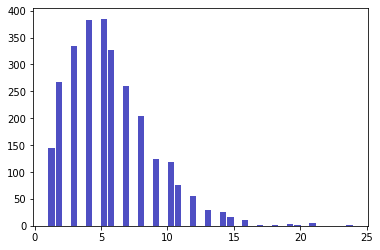

In [12]:
import matplotlib.pyplot as plt

_, num_chains = zip(*active_chains)
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=num_chains, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [13]:
def get_len_stats_for_file(train_file):
    print(train_file)
    data = load_jsonl(train_file)
    max_active_chains = 0
    corr_doc_idx = None
    within_doc_idx = None

    chain_spread = []
    active_chains = []
    for doc_idx, instance in enumerate(data):
        cluster_spans = get_cluster_spans(instance["clusters"])
        doc_len = len(instance["sentence_map"])
        if len(cluster_spans):
            
            for (span_start, span_end) in cluster_spans:
                chain_spread.append((span_end - span_start + 1)/doc_len)
            doc_tokens = get_doc_tokens(instance["sentences"])
            instance_max_active_chains, instance_within_doc_idx = get_max_active_chains(cluster_spans)
            if max_active_chains < instance_max_active_chains:
                max_active_chains = instance_max_active_chains
                corr_doc_idx = doc_idx
                within_doc_idx = instance_within_doc_idx
            
            active_chains.append((instance["doc_key"], instance_max_active_chains))
    print("Max active chains: {} present in {}".format(max_active_chains, data[corr_doc_idx]["doc_key"]))
    return chain_spread

/home/shtoshni/Research/litbank_coref/data/ontonotes/independent/train.512.jsonlines
Max active chains: 24 present in nw/wsj/13/wsj_1366_0


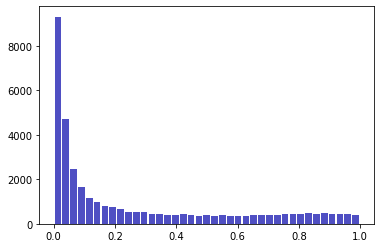

In [17]:
data_dir = "/home/shtoshni/Research/litbank_coref/data/ontonotes/independent"
train_file = path.join(data_dir, "train.512.jsonlines")
chain_spread = get_len_stats_for_file(train_file)

# print(chain_spread)

import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=chain_spread, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.savefig()